In [51]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib
import seaborn as sns

In [5]:
def new_fig(size, ncols=1, nrows=1, show_spines=True):
    '''
    size - [widthXheight] in cm
    '''
    
    cm = 1/2.54
    f, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(np.array(size)*cm))
    if not show_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    matplotlib.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
    
    return f, ax


def save_fig(filepath):
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.savefig(filepath + '.pdf', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filepath + '.jpg', transparent=True, dpi=300, bbox_inches='tight')

# Loading the data

In [6]:
def hair_data_long_to_wide(data_df):
    '''
    organizes the dataframe in a matrix form of [#subjects X #time]
    '''
    
    orig_and_repeats_to_mat = data_df.pivot_table(
        values='value',
        index=['id', 'type'],
        columns='segment'
    ).reset_index()
    raw_data_mat = orig_and_repeats_to_mat[np.arange(6)].to_numpy().T
    
    return raw_data_mat, orig_and_repeats_to_mat

In [7]:
# New healthy controls
new_control_path = '../data/new controls.xlsx'
new_control_data = pd.read_excel(new_control_path, sheet_name='Sheet1', index_col=0, nrows=6)

new_control_data = new_control_data.T.reset_index()
new_control_data.rename(columns={'index': 'id'}, inplace=True)
new_control_data = pd.melt(new_control_data, id_vars=['id'], var_name='segment')
new_control_data['value'] = pd.to_numeric(new_control_data['value'])
new_control_data['segment'] = pd.to_numeric(new_control_data['segment'])
new_control_data['id'] = new_control_data['id'].astype(str)
new_control_data['type'] = 'o'

clean_new_control = new_control_data.copy()
clean_new_control.loc[clean_new_control['value'] <= 0, 'value'] = np.NaN
clean_new_control_mat, clean_new_control_df = hair_data_long_to_wide(clean_new_control)

# Removing patients with cortisol <= 0
valid_subjects_idx = np.all(np.isfinite(clean_new_control_df[np.arange(0, 6)]), axis=1)
print(f'{np.sum(valid_subjects_idx)}/{len(clean_new_control_df)} remained after removing <=0 cortisol values')
clean_new_control_df = clean_new_control_df[valid_subjects_idx]
clean_new_control_df.reset_index(inplace=True, drop=True)

############################
# Removing outliers
############################
outliers = ['HC2', 'HC3', 'HC4'] # had very high CV after normalization (> 3 std from the mean CV)
outliers += ['HC1'] # had very high mean raw cortisol level (> 3 stds from the mean raw cortisol)
clean_new_control_df.set_index('id', inplace=True)
clean_new_control_df.drop(index=outliers, inplace=True)
clean_new_control_df.reset_index(inplace=True)
print(f'{len(outliers)} outliers were removed')

clean_new_control_mat = clean_new_control_df[np.arange(0,6)].to_numpy().T
clean_new_control_df

27/33 remained after removing <=0 cortisol values
4 outliers were removed


segment,id,type,0,1,2,3,4,5
0,HC11,o,3.256989,1.820725,0.145587,0.120955,0.250868,0.569181
1,HC12,o,9.096934,7.082512,3.363245,3.366343,2.115335,1.433720
2,HC13,o,6.343394,2.855937,1.538529,0.330503,0.778121,0.469104
3,HC15,o,5.906811,3.831610,2.176162,4.315000,3.487922,4.167260
4,HC16,o,5.841681,7.293736,8.761119,7.317197,4.801151,5.280037
5,HC17,o,5.662344,5.183842,2.763802,2.861566,2.135669,2.341801
6,HC18,o,5.598391,2.583679,5.336959,5.404428,2.819930,2.082997
7,HC19,o,7.223997,5.771962,1.436361,5.974840,1.426599,2.519567
8,HC20,o,122.067563,124.348921,104.438922,64.746520,42.856541,21.895270
9,HC21,o,6.076066,3.464125,1.965494,2.086689,2.042626,2.214322


In [8]:
# Old healthy controls
old_control_path = '../data/old controls.xlsx'
old_control_data = pd.read_excel(old_control_path, sheet_name='proccessed', index_col=0, nrows=8)
old_control_data = old_control_data.T.reset_index()
old_control_data.rename(columns={'index': 'id'}, inplace=True)
old_control_data = pd.melt(old_control_data, id_vars=['id', 'subject ID', 'type'], var_name='segment')
old_control_data['value'] = pd.to_numeric(old_control_data['value'])
old_control_data['segment'] = pd.to_numeric(old_control_data['segment'])
old_control_data['id'] = old_control_data['id'].astype(str)

clean_old_control = old_control_data.copy()
clean_old_control.loc[clean_old_control['value'] <= 0, 'value'] = np.NaN
clean_old_control_mat, clean_old_control_df = hair_data_long_to_wide(clean_old_control)

# Removing repeats:
repeat_idx = clean_old_control_df.loc[clean_old_control_df['type'].str.contains('r')].index
print(f'{len(repeat_idx)}/{len(clean_old_control_df)} repeates removed')
clean_old_control_df.drop(index=repeat_idx, inplace=True)
clean_old_control_df.reset_index(inplace=True, drop=True)

# Removing subjects that are both in the old and the new control groups:
new_control_path = '../data/new controls.xlsx'
id_list = pd.read_excel(new_control_path, sheet_name='meta', index_col=0, usecols='A:B')
double_ids = set(id_list['old id'].astype(str)).intersection(set(clean_old_control_df['id']))
print(f'{len(double_ids)}/{len(clean_old_control_df)} doubles removed from old (that appear also in new controls)')
clean_old_control_df = clean_old_control_df[~clean_old_control_df['id'].isin(double_ids)]

# Removing patients with cortisol <= 0
valid_subjects_idx = np.all(np.isfinite(clean_old_control_df[np.arange(0, 6)]), axis=1)
print(f'{np.sum(valid_subjects_idx)}/{len(clean_old_control_df)} remained after removing <=0 cortisol values')
clean_old_control_df = clean_old_control_df[valid_subjects_idx]
clean_old_control_df.reset_index(inplace=True, drop=True)

############################
# Removing outliers
############################
# No outliers in old dataset

clean_old_control_mat = clean_old_control_df[np.arange(0,6)].to_numpy().T
clean_old_control_df

14/73 repeates removed
21/59 doubles removed from old (that appear also in new controls)
36/38 remained after removing <=0 cortisol values


segment,id,type,0,1,2,3,4,5
0,10,o,75.301219,48.543408,37.687261,30.296770,10.501013,8.797197
1,11,o,30.450298,37.185843,22.942149,11.384494,13.433550,12.928933
2,15,o,17.078175,9.705966,6.515129,4.528280,1.921390,0.586277
3,22,o,5.204285,2.899145,1.322078,0.683271,0.655057,0.400656
4,24,o,6.242099,2.894727,1.512206,0.792707,0.958133,0.291631
5,25,o,66.153724,13.161433,24.580669,11.551049,5.603959,9.675568
6,27,o,13.063454,14.909647,9.932516,6.407274,3.982811,4.535760
7,29,o,6.040208,7.482049,6.621392,2.035787,2.929159,3.247282
8,30,o,10.649688,3.213917,1.436931,0.789211,1.667007,2.625515
9,31,o,5.524529,5.906508,3.231577,3.066217,1.700133,1.683946


In [9]:
clean_all_control_mat = np.concatenate((clean_new_control_mat, clean_old_control_mat), axis=1)
clean_all_control_mat.shape

(6, 59)

In [10]:
bp_replicates_first = pd.read_excel('../data/bipolar.xlsx', sheet_name='data for repeats analysis', header=0, nrows=6, usecols='A:M')
# Removing patients with cortisol <= 0
cols_to_keep = (bp_replicates_first > 0).all(axis=0)
bp_replicates_first.drop(columns=bp_replicates_first.columns[~cols_to_keep], inplace=True)
print(f'{np.sum(~cols_to_keep)} patients removed from first repeat dataset due to zero or lower cortisol')
bp_replicates_first_mat = bp_replicates_first.to_numpy()
print(f'{bp_replicates_first_mat.shape[1]} first repeats')

bp_replicates_second = pd.read_excel('../data/bipolar.xlsx', sheet_name='data for repeats analysis', header=7, nrows=6, usecols='A:M')
# Removing patients with cortisol <= 0
cols_to_keep = (bp_replicates_second > 0).all(axis=0)
bp_replicates_second.drop(columns=bp_replicates_second.columns[~cols_to_keep], inplace=True)
print(f'{np.sum(~cols_to_keep)} patients removed from second repeat dataset due to zero or lower cortisol')
bp_replicates_second_mat = bp_replicates_second.to_numpy()
print(f'{bp_replicates_second_mat.shape[1]} second repeats')

bp_nonreplicates = pd.read_excel('../data/bipolar.xlsx', sheet_name='data for repeats analysis', header=15, nrows=6)
# Removing patients with cortisol <= 0
cols_to_keep = (bp_nonreplicates > 0).all(axis=0)
bp_nonreplicates.drop(columns=bp_nonreplicates.columns[~cols_to_keep], inplace=True)
print(f'{np.sum(~cols_to_keep)} patients removed from non-repeat dataset due to zero or lower cortisol')
############################
# Removing outliers
############################
outliers = ['BP5', 'BP30'] # had very high mean raw cortisol level (> 3 stds from the mean raw cortisol)
bp_nonreplicates.drop(columns=outliers, inplace=True)
bp_nonreplicates_mat = bp_nonreplicates.to_numpy()
print(f'{bp_nonreplicates_mat.shape[1]} non repeats')

0 patients removed from first repeat dataset due to zero or lower cortisol
13 first repeats
0 patients removed from second repeat dataset due to zero or lower cortisol
13 second repeats
0 patients removed from non-repeat dataset due to zero or lower cortisol
13 non repeats


# Data analysis

## Raw cortisol

### Averaging first and second replicates

In [8]:
control_df = pd.merge(clean_old_control_df, clean_new_control_df, how='outer')
control_df.drop(columns='type', inplace=True)
control_df = control_df.melt(id_vars='id', value_name='cortisol')
control_df['type'] = 'control'
control_df

,id,segment,cortisol,type
0,10,0,75.301219,control
1,11,0,30.450298,control
2,15,0,17.078175,control
3,22,0,5.204285,control
4,24,0,6.242099,control
...,...,...,...,...
349,HC34,5,1.374629,control
350,HC35,5,2.598633,control
351,HC36,5,4.572631,control
352,HC6,5,3.199502,control


In [9]:
bp_f_melt = bp_replicates_first.reset_index()
bp_f_melt.rename(columns={'index': 'segment'}, inplace=True)
bp_f_melt = bp_f_melt.melt(id_vars='segment',var_name='id', value_name='cortisol')

bp_s_melt = bp_replicates_second.reset_index()
bp_s_melt.rename(columns={'index': 'segment'}, inplace=True)
bp_s_melt = bp_s_melt.melt(id_vars='segment',var_name='id', value_name='cortisol')

bp_replicates_melt = pd.concat([bp_f_melt, bp_s_melt])

bp_mean_melt = pd.concat([bp_f_melt, bp_s_melt]).groupby(by=['id', 'segment']).agg('mean')
bp_mean_melt.reset_index(inplace=True)

bp_n_melt = bp_nonreplicates.reset_index()
bp_n_melt.rename(columns={'index': 'segment'}, inplace=True)
bp_n_melt = bp_n_melt.melt(id_vars='segment',var_name='id', value_name='cortisol')

bp_all = pd.concat([bp_mean_melt, bp_n_melt], ignore_index=True)
bp_all['type'] = 'bipolar'
bp_all

,id,segment,cortisol,type
0,BP10,0,87.627666,bipolar
1,BP10,1,60.962981,bipolar
2,BP10,2,30.245498,bipolar
3,BP10,3,20.667281,bipolar
4,BP10,4,14.811647,bipolar
...,...,...,...,...
151,BP33,1,6.068099,bipolar
152,BP33,2,1.424015,bipolar
153,BP33,3,1.564896,bipolar
154,BP33,4,1.206383,bipolar


In [10]:
all_participants = pd.concat([control_df, bp_all], ignore_index=True)
all_participants['log10_cortisol'] = np.log10(all_participants['cortisol'])
all_participants['segment'] += 1
all_participants

,id,segment,cortisol,type,log10_cortisol
0,10,1,75.301219,control,1.876802
1,11,1,30.450298,control,1.483592
2,15,1,17.078175,control,1.232441
3,22,1,5.204285,control,0.716361
4,24,1,6.242099,control,0.795331
...,...,...,...,...,...
505,BP33,2,6.068099,bipolar,0.783053
506,BP33,3,1.424015,bipolar,0.153514
507,BP33,4,1.564896,bipolar,0.194486
508,BP33,5,1.206383,bipolar,0.081485


### Raw cortisol comparison

Mann Whitney u test for segment 1: p=0.008

Mann Whitney u test for segment 2: p=0.003

Mann Whitney u test for segment 3: p=0.012

Mann Whitney u test for segment 4: p=0.042

Mann Whitney u test for segment 5: p=0.005

Mann Whitney u test for segment 6: p=0.012



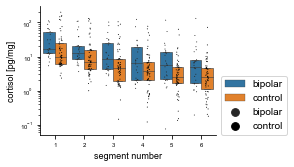

In [15]:
criterion = 'cortisol'

f, ax = new_fig((8, 6), show_spines=False)
# sns.boxplot(x='segment', y=criterion, hue='type', hue_order=['bipolar', 'control'], data=all_participants, showfliers=False, linewidth=0.6)
sns.boxplot(x='segment', y=criterion, hue='type', hue_order=['bipolar', 'control'], data=all_participants, showfliers=False, linewidth=0.6, whis=0) # without whiskers
sns.stripplot(x='segment', y=criterion, hue='type', hue_order=['bipolar', 'control'], data=all_participants, dodge=True, color='black', size=1)
plt.yscale('log')
plt.xlabel('segment number', size=9)
plt.xticks(fontsize=6)
plt.ylabel('cortisol [pg/mg]', size=9)
plt.yticks(fontsize=6)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
# save_fig('../results/raw_cort_per_segment_wo_whisker')

for segment in sorted(all_participants.segment.unique()):
    u, p = st.mannwhitneyu(
        all_participants.loc[(all_participants.segment == segment) & (all_participants.type == 'bipolar'), criterion], 
        all_participants.loc[(all_participants.segment == segment) & (all_participants.type == 'control'), criterion], 
        alternative='greater'
    )
    print(f'Mann Whitney u test for segment {segment}: p={p:0.3f}')
    print()

TypeError: got an unexpected keyword argument 'labels'

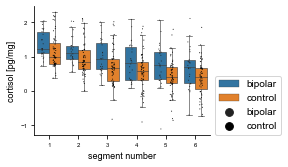

In [12]:
# plot it again in log scale with correct whisker
y_tick_labels = ax.get_yticklabels()
locations = [y_tick_label.get_position()[1] for y_tick_label in y_tick_labels]
labels = [y_tick_label.get_text() for y_tick_label in y_tick_labels]
ylim = ax.get_ylim()

criterion = 'log10_cortisol'

f, ax = new_fig((8, 6), show_spines=False)
sns.boxplot(x='segment', y=criterion, hue='type', hue_order=['bipolar', 'control'], data=all_participants, showfliers=False, linewidth=0.6)
sns.stripplot(x='segment', y=criterion, hue='type', hue_order=['bipolar', 'control'], data=all_participants, dodge=True, color='black', size=1)
plt.xlabel('segment number', size=9)
plt.xticks(fontsize=6)
plt.ylabel('cortisol [pg/mg]', size=9)
plt.yticks(fontsize=6)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
ax.set_yticks(ticks=np.log10(locations), labels=labels)
plt.ylim(np.log10(ylim))
# save_fig('../results/raw_cort_per_segment')

#### Bootstrapping statistics

In [39]:
def calculate_stats(
    sample_x,
    sample_y,
    name_x,
    name_y,
    stat_name,
    n_boots=5000,
    alternative=None,
    name=None,
    estimator=np.mean,
    plot=True,
):
    
    print(f'#{name_x}={len(sample_x)}, #{name_y}={len(sample_y)}')
    s, p = st.mannwhitneyu(sample_x, sample_y, alternative=alternative)
    print(f'Mann Whitney p = {p:0.4f}')
    print(f'median({name_x} {stat_name}) / median({name_y} {stat_name}) = {np.median(sample_x)/np.median(sample_y):0.2f}')
    
    if plot:
        f, ax = new_fig((6, 6/4*3), show_spines=False)
        sns.boxplot(data=[sample_x, sample_y], showfliers=False, linewidth=0.6, width=0.3)
        sns.stripplot(data=[sample_x, sample_y], color='black', size=1)
        plt.xticks([0,1], [name_x, name_y], fontsize=9)
        plt.yticks(fontsize=6)
        plt.ylabel(stat_name, size=9)
        if name is not None:
            save_fig(f'../results/{name}')

    boot_ratio = np.zeros(n_boots)
    for i in range(n_boots):
        boot_x = np.random.choice(sample_x, size=len(sample_x))
        boot_y = np.random.choice(sample_y, size=len(sample_y))
        boot_ratio[i] = estimator(boot_x)/estimator(boot_y)
    
    if plot:
        plt.figure(figsize=(4*2, 3*2))
        plt.hist(boot_ratio, bins='auto', color='gray', alpha=0.6)
        plt.tick_params(axis='x', labelsize=16)
        plt.yticks([])
        plt.xlabel(f'<{name_x} {stat_name}>/<{name_y} {stat_name}>', size=20)
        plt.title('Bootstrapping', size=25)
    print(f'95% interval = [{np.quantile(boot_ratio, 0.025):0.2f}, {np.quantile(boot_ratio, 0.975):0.2f}]')
    print(f'5%={np.quantile(boot_ratio, 0.05):0.2f}')

In [17]:
all_participants_pivot = all_participants.drop(columns='log10_cortisol').pivot_table(index=['id', 'type'], columns='segment').reset_index()
all_participants_pivot

id     type   cortisol                                              \
segment                         1          2          3          4          5   
0          10  control  75.301219  48.543408  37.687261  30.296770  10.501013   
1          11  control  30.450298  37.185843  22.942149  11.384494  13.433550   
2          15  control  17.078175   9.705966   6.515129   4.528280   1.921390   
3          22  control   5.204285   2.899145   1.322078   0.683271   0.655057   
4          24  control   6.242099   2.894727   1.512206   0.792707   0.958133   
..        ...      ...        ...        ...        ...        ...        ...   
80       HC34  control   6.165335   5.155539   1.229511   1.947492   0.810455   
81       HC35  control   7.952514   4.457264   4.718803   2.112714   2.033217   
82       HC36  control  32.537184  21.987422   4.971103   6.655041   2.463912   
83        HC6  control  17.590948  15.058703  13.852068   7.691577   4.919531   
84        HC8  control  56.787829  67.792148  44.032031  49.715902  17.960778   

                    
segment          6  
0         8.797197  
1        12.928933  
2         0.586277  
3         0.400656  
4         0.291631  
..             ...  
80        1.374629  
81        2.598633  
82        4.572631  
83        3.199502  
84        7.101643  

[85 rows x 8 columns]

In [18]:
all_participants_pivot.type.value_counts()

control    59
bipolar    26
Name: type, dtype: int64

In [19]:
control_cortisol = all_participants_pivot.loc[all_participants_pivot['type'] == 'control', 'cortisol'].values
bipolar_cortisol = all_participants_pivot.loc[all_participants_pivot['type'] == 'bipolar', 'cortisol'].values

In [26]:
for segment in range(6):
    print(f'stats for segment{segment+1}')
    calculate_stats(
        bipolar_cortisol[:, segment],
        control_cortisol[:, segment],
        'bipolar',
        'control',
        f'seg{segment+1} cortisol',
        alternative='greater',
        n_boots=1000,
        plot=False,
        estimator=np.median,
    )
    print()

stats for segment1
#bipolar=26, #control=59
Mann Whitney p = 0.0076
median(bipolar seg1 cortisol) / median(control seg1 cortisol) = 1.74
95% interval = [1.03, 3.43]
5%=1.17

stats for segment2
#bipolar=26, #control=59
Mann Whitney p = 0.0031
median(bipolar seg2 cortisol) / median(control seg2 cortisol) = 1.83
95% interval = [1.20, 3.00]
5%=1.29

stats for segment3
#bipolar=26, #control=59
Mann Whitney p = 0.0120
median(bipolar seg3 cortisol) / median(control seg3 cortisol) = 1.85
95% interval = [0.93, 3.66]
5%=0.98

stats for segment4
#bipolar=26, #control=59
Mann Whitney p = 0.0417
median(bipolar seg4 cortisol) / median(control seg4 cortisol) = 1.73
95% interval = [0.63, 4.03]
5%=0.73

stats for segment5
#bipolar=26, #control=59
Mann Whitney p = 0.0054
median(bipolar seg5 cortisol) / median(control seg5 cortisol) = 2.21
95% interval = [0.98, 5.36]
5%=1.09

stats for segment6
#bipolar=26, #control=59
Mann Whitney p = 0.0118
median(bipolar seg6 cortisol) / median(control seg6 cortisol) 

# Cortisol spectral analysis

In [46]:
def normalize_by_trend(data, bounds=([0, 0.0001], np.inf), with_mean=False, exp=False, ax=None):
    
    linear = lambda t, A, alpha: np.log(A) - alpha*t
    y = np.log(data.cortisol)
    t = data.segment
    popt, pcov = curve_fit(linear, t, y, bounds=bounds)
    
    if with_mean:
        normalized = y + popt[1]*t
    else:
        normalized = y - np.log(popt[0]) + popt[1]*t
    if exp:
        normalized = np.exp(normalized)
    
    if ax is not None:
        colors = sns.color_palette(palette='tab10', n_colors=2)
        sns.lineplot(
            x=t+1,
            y=normalized.values,
            color=colors[1] if data.label.unique()[0] == 'control' else colors[0],
            alpha=0.2 if data.label.unique()[0] == 'control' else 0.6,
            ax=ax,
            lw=0.6
        )
    
    return normalized


def calculate_fft(df):
    
    s = df.cortisol.values
    amps = np.abs(np.fft.rfft(s))
    freqs = np.fft.rfftfreq(len(s), 2/12)
    
    return pd.DataFrame(data={'frequency': freqs, 'amplitude': amps})


def normalize_and_fourier(data, with_mean, exp, yscale='', save=False):
    
    f, ax = new_fig(size=(6, 6/4*3))
    normalized = data[['cortisol', 'id', 'label', 'sample', 'segment']].groupby(['id', 'sample', 'label']).apply(
        normalize_by_trend,
        exp=exp,
        with_mean=with_mean,
        ax=ax
    ).reset_index().rename(columns={0: 'cortisol'}).drop(columns='level_3')
    ax.set_xlabel('hair segment', size=8)
    ax.set_ylabel('cortisol [pg/mg]', size=8)
    ax.tick_params(axis='both', labelsize=6)
    sns.despine(ax=ax)
    if yscale == 'log':
        ax.set_yscale('log')
    if save:
        save_fig('../results/cortisol_corrected_timeseries')

    fft = normalized.groupby(['id', 'sample', 'label']).apply(calculate_fft).reset_index().drop(columns='level_3')
    fft = fft.groupby(['id', 'frequency', 'label']).agg('mean').reset_index() # averaging bipolar repeated measurments
    fft['frequency'] = fft['frequency'].astype(int)

    # check whether we have replicates:
    counts = fft.id.value_counts()
    if sum(counts != 4) == 0:
        print('no replicates - we can continue')
    else:
        print(f'we have replicate: {counts[counts != 4]}')

    print(f'N_control={fft[fft.label == "control"].id.nunique()}')
    print(f'N_bipolar={fft[fft.label == "bipolar"].id.nunique()}')
    
    # plot mean/median amplitudes
    f, ax = new_fig(size=(6, 6/4*3))
    estimator = 'median'
    sns.pointplot(
        data=fft[fft.frequency != 0],
        x='frequency',
        y='amplitude',
        hue='label',
        ci=68,
        ax=ax,
        estimator=np.median if estimator == 'median' else np.mean,
        hue_order=['bipolar', 'control'],
        scale=0.7,
    )
    sns.despine(ax=ax)
    ax.set_xlabel('frequency [1/year]', size=8)
    ax.set_ylabel(f'{estimator} cortisol\namplitude [pg/mg]', size=8)
    if yscale == 'log':
        ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=6)
    ax.legend([],[], frameon=False)
    if save:
        save_fig(f'../results/{estimator}_cortisol_amplitude')
    
    # plot box plots of amplitudes
    f, ax = new_fig(size=(6, 6/4*3))
    sns.boxplot(data=fft[fft.frequency != 0], x='frequency', y='amplitude', hue='label', ax=ax, showfliers=False, whis=0, hue_order=['bipolar', 'control'], linewidth=0.6)
    sns.stripplot(data=fft[fft.frequency != 0], x='frequency', y='amplitude', hue='label', ax=ax, dodge=True, color='black', size=1, hue_order=['bipolar', 'control'])
    sns.despine(ax=ax)
    ax.set_xlabel('frequency [1/year]', size=8)
    ax.set_ylabel('cortisol amplitude [pg/mg]', size=8)
    ax.tick_params(axis='both', labelsize=6)
    if yscale == 'log':
        ax.set_yscale('log')
    ax.legend([],[], frameon=False)
    if save:
        save_fig(f'../results/cortisol_amplitude_box_plot')
    plt.show()

    # Some statistics
    for freq in fft.frequency.unique():
        print(f'bipolar vs. control in freq={freq}:\n')
        
        bipolar_amps = fft.loc[(fft.label == "bipolar") & (fft.frequency == freq), "amplitude"]
        control_amps = fft.loc[(fft.label == "control") & (fft.frequency == freq), "amplitude"]
        
        calculate_stats(bipolar_amps, control_amps, 'bipolar', 'control', f'amp(freq{int(freq)})', alternative='greater', n_boots=1000, plot=False, estimator=np.median)
        print()
    
    low_bipolar_amps = fft.loc[(fft.label == "bipolar") & (fft.frequency == 1), "amplitude"]
    high_bipolar_amps = fft.loc[(fft.label == "bipolar") & (fft.frequency == 3), "amplitude"]
    low_control_amps = fft.loc[(fft.label == "control") & (fft.frequency == 1), "amplitude"]
    high_control_amps = fft.loc[(fft.label == "control") & (fft.frequency == 3), "amplitude"]
    
    print()
    calculate_stats(low_bipolar_amps, high_bipolar_amps, 'low freq (bipolar)', 'high freq (bipolar)', 'amp', alternative='greater', n_boots=1000, plot=False, estimator=np.median)
    print()
    calculate_stats(low_control_amps, high_control_amps, 'low freq (control)', 'high freq (control)', 'amp', alternative='greater', n_boots=1000, plot=False, estimator=np.median)
    
    return normalized

In [44]:
tmp_first = bp_replicates_first.reset_index().rename(columns={'index': 'segment'}).melt(id_vars='segment', var_name='id', value_name='cortisol')
tmp_first['sample'] = 1

tmp_second = bp_replicates_second.reset_index().rename(columns={'index': 'segment'}).melt(id_vars='segment', var_name='id', value_name='cortisol')
tmp_second['sample'] = 2

tmp_nonreplicates = bp_nonreplicates.reset_index().rename(columns={'index': 'segment'}).melt(id_vars='segment', var_name='id', value_name='cortisol')
tmp_nonreplicates['sample'] = 1

tmp_bd = pd.concat((tmp_first, tmp_second, tmp_nonreplicates))
tmp_bd['label'] = 'bipolar'

tmp_control = pd.concat((clean_old_control_df, clean_new_control_df)).drop(columns='type')
tmp_control = tmp_control.melt(id_vars='id', value_name='cortisol')
tmp_control['sample'] = 1
tmp_control['label'] = 'control'

data = pd.concat((tmp_control, tmp_bd), ignore_index=True)
data['time'] = 2*(5 - data.segment)
data['segment'] = data['segment'].astype(int)
data

,id,segment,cortisol,sample,label,time
0,10,0,75.301219,1,control,10
1,11,0,30.450298,1,control,10
2,15,0,17.078175,1,control,10
3,22,0,5.204285,1,control,10
4,24,0,6.242099,1,control,10
...,...,...,...,...,...,...
583,BP33,1,6.068099,1,bipolar,8
584,BP33,2,1.424015,1,bipolar,6
585,BP33,3,1.564896,1,bipolar,4
586,BP33,4,1.206383,1,bipolar,2


meta NOT subset; don't know how to subset; dropped


no replicates - we can continue
N_control=59
N_bipolar=26


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


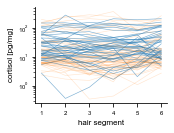

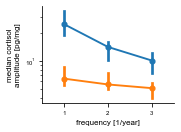

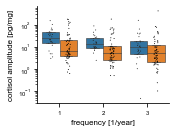

bipolar vs. control in freq=0:

#bipolar=26, #control=59
Mann Whitney p = 0.0009
median(bipolar amp(freq0)) / median(control amp(freq0)) = 2.06
95% interval = [1.28, 3.71]
5%=1.45

bipolar vs. control in freq=1:

#bipolar=26, #control=59
Mann Whitney p = 0.0010
median(bipolar amp(freq1)) / median(control amp(freq1)) = 3.90
95% interval = [1.72, 7.01]
5%=2.11

bipolar vs. control in freq=2:

#bipolar=26, #control=59
Mann Whitney p = 0.0003
median(bipolar amp(freq2)) / median(control amp(freq2)) = 2.55
95% interval = [1.37, 4.03]
5%=1.53

bipolar vs. control in freq=3:

#bipolar=26, #control=59
Mann Whitney p = 0.0199
median(bipolar amp(freq3)) / median(control amp(freq3)) = 1.99
95% interval = [1.10, 4.05]
5%=1.16


#low freq (bipolar)=26, #high freq (bipolar)=26
Mann Whitney p = 0.0059
median(low freq (bipolar) amp) / median(high freq (bipolar) amp) = 2.48
95% interval = [1.27, 5.23]
5%=1.49

#low freq (control)=59, #high freq (control)=59
Mann Whitney p = 0.0204
median(low freq (contr

In [47]:
normalized = normalize_and_fourier(data, with_mean=True, exp=True, yscale='log', save=True)

# Risk for mania by prednisone dose

Fardet 2012 - Suicidal Behavior and Severe Neuropsychiatric Disorders Following Glucocorticoid Therapy in Primary Care

meta NOT subset; don't know how to subset; dropped


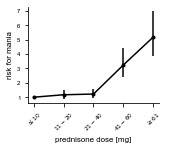

In [64]:
prednisone = ['$\leq10$', '$11-20$', '$21-40$', '$41-60$', '$\geq61$']
mania_risk = np.array([1, 1.17, 1.22, 3.24, 5.18])
lower_error = np.array([1, 0.9, 0.97, 2.39, 3.85])
upper_error = np.array([1, 1.53, 1.54, 4.38, 6.97])
f, ax = new_fig((6, 3/4*6), show_spines=False)
plt.errorbar(prednisone, mania_risk, [mania_risk-lower_error, upper_error-mania_risk], fmt='.-', color='black')
plt.tick_params(labelsize=6)
plt.tick_params(axis='x', labelrotation=45)
plt.ylabel('risk for mania', size=8)
plt.xlabel('prednisone dose [mg]', size=8)
save_fig('../figures/bipolar vs healthy/risk for mania vs prednisone')